# Problem Statement

Creating a good text classification model is important to making online communities more engaging and helping users find content they are interested in. This project goal is to build a machine learning model that can automatically categorize online posts as either about "music" or "movies". We'll train this model using a dataset of labeled text from online posts to learn patterns and relationships between words and categories.

The success of the model is evaluated by looking at how accurately it can classify new posts, checking metrics like accuracy, precision, recall, and F1-score. The focus here is on sorting text from posts found in "movies" and "music" subreddits. This research is important because precise text classification can greatly improve how people discover content online and interact with it.

This project has benefits for different groups. Community users, social media platforms, and content creators will all benefit from better content discovery and happier users. Advertisers, content moderators, and researchers in natural language processing and human-computer  will also benefit from the insights and methodologies developed in this project. By considering everyone's needs, the goal of this project is to create a text classification model that is practical and useful in real-world situations.

In [ ]:
# !pip install praw

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import praw
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from wordcloud import WordCloud
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data Collection

In [ ]:
reddit = praw.Reddit(
    client_id='YOUR_CLIENT_ID',
    client_secret='YOUR_CLIENT_SECRET',
    user_agent='YOUR_USER_AGENT',
    username='YOUR_REDDIT_USERNAME',
    password='YOUR_REDDIT_PASSWORD'
)

In [ ]:
def collect_posts(subreddit_name, num_posts):
    subreddit = reddit.subreddit(subreddit_name)
    data = []
    processed_post_ids = set()  # set to store processed post IDs
    count = 0
    skipped_count = 0  # counter for skipped posts

    while len(data) < num_posts:
        try:
            # fetch posts in batches of 2000 (max limit per request) - 2000 allows to collect enough posts
            posts = subreddit.new(limit=min(2000, num_posts - len(data)))
            for post in posts:
                if post.id not in processed_post_ids:  # check if post is not processed
                    # check if the post author exists and has an ID attribute
                    if post.author and hasattr(post.author, 'id'):
                        author_id = post.author.id
                    else:
                        author_id = None  # set author_id as None if not found

                    # Check if 'title' and 'selftext' are not empty or NaN
                    if post.title.strip() and post.selftext.strip():
                        # append post details to data list
                        data.append([author_id,
                                     post.id,
                                     post.created_utc,
                                     post.title,
                                     post.selftext,
                                     post.subreddit])
                        count += 1
                        if count % 5 == 0:
                            print(f'Collected {count} posts...')
                        if len(data) >= num_posts:
                            break
                    else:
                        skipped_count += 1
                        if skipped_count % 5 == 0:
                            print(f'{skipped_count} posts skipped...')
                time.sleep(1)  # delay for API rate limits
        except Exception as e:
            print(f'Error occurred: {str(e)}')
            time.sleep(60)  # pause for one minute in case of error

    print(f'Total posts collected: {count}')
    print(f'Total posts skipped: {skipped_count}')

    return pd.DataFrame(data, columns=['author_id', 'post_id', 'created_utc', 'title', 'self_text', 'subreddit'])

In [ ]:
# number of posts to collect per subreddit
num_posts_per_subreddit = 1000

In [ ]:
# collect movie posts
movies_df = collect_posts('movies', num_posts_per_subreddit)

In [ ]:
# collect movie posts
movies_df = collect_posts('movies', num_posts_per_subreddit)

In [ ]:
# save dfs to csv
movies_df.to_csv("./data/movies_posts.csv", index=False)
music_df.to_csv("./data/music_posts.csv", index=False)

In [ ]:
movie = pd.read_csv("./data/movies_posts.csv")
movie.head()

,author_id,post_id,created_utc,title,self_text,subreddit
0,2a05de1,1cd3pko,1.714081e+09,How much longer will Dune 2 be in theaters?,I lost my glasses a couple weeks ago and won’t...,movies
1,w71lonuwc,1cd3p8r,1.714081e+09,where is humane showing?,okay so ive been really excited for humane to ...,movies
2,w3vcatnq,1cd3kpd,1.714081e+09,A Promising Young Woman (Ryan Cooper),I just watched this movie this morning. It was...,movies
3,1qu8acfj,1cd2r1s,1.714079e+09,Incident at Haystack Landing (1999 movie),Hello all! I am looking for a movie called Inc...,movies
4,xj8fsllj5,1cd2ggf,1.714078e+09,Let's talk about villains that are actually right,"We've seen a lot of movies where the villain, ...",movies


In [ ]:
music = pd.read_csv("./data/music_posts.csv")
music.head()

,author_id,post_id,created_utc,title,self_text,subreddit
0,w8zaruyv,1cd48pg,1.714083e+09,What artist in your opinion had the best live ...,What artist in you opinion had the best live p...,Music
1,p4sbp4n8,1cd4536,1.714083e+09,What musicians/bands you think are technically...,\nhere is ed sheeran \nhe has a nice voice ...,Music
2,3xdtpru7,1cd3p3q,1.714081e+09,Help finding a band I can't remember.,"I'm looking for a british band, \n70's rock st...",Music
3,ampy9wid,1cd3jsc,1.714081e+09,Who actually listened to dance monkey?,It has 3 billion streams and im not sure if i ...,Music
4,xcwx1nm0b,1cd3hlx,1.714081e+09,An unfamiliar experience,(Not white sure if these types of posts are al...,Music


# Data Cleaning and EDA

Data is collected to make sure that there is no missing values for the main features '`title`' and '`self_text`'that will be used to train the model. There are only 8 missing for `author_id`, and since this is not significant or not needed to train the model, this can be ignored

In [ ]:
movie.isnull().sum()

author_id      8
post_id        0
created_utc    0
title          0
self_text      0
subreddit      0
dtype: int64

In [ ]:
music.isnull().sum()

author_id      0
post_id        0
created_utc    0
title          0
self_text      0
subreddit      0
dtype: int64

In [ ]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   author_id    992 non-null    object 
 1   post_id      1000 non-null   object 
 2   created_utc  1000 non-null   float64
 3   title        1000 non-null   object 
 4   self_text    1000 non-null   object 
 5   subreddit    1000 non-null   object 
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


In [ ]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   author_id    1000 non-null   object 
 1   post_id      1000 non-null   object 
 2   created_utc  1000 non-null   float64
 3   title        1000 non-null   object 
 4   self_text    1000 non-null   object 
 5   subreddit    1000 non-null   object 
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


In [ ]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    '''
    This function preprocesses text by converting to lower case, removing non-alphabetic tokens and stop words
    '''
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if token.is_alpha and token.text.lower() not in STOP_WORDS]
    return tokens

# tokenize and preprocess the text in the 'post' column for movies dataframe
movie['clean_post'] = (movie['title'] + ' ' + movie['self_text']).apply(preprocess_text)
# tokenize and preprocess the text in the 'post' column for music dataframe
music['clean_post'] = (music['title'] + ' ' + music['self_text']).apply(preprocess_text)

# flatten the list of tokens for each subreddit
movie_all_tokens = [token for sublist in movie['clean_post'] for token in sublist]
music_all_tokens = [token for sublist in music['clean_post'] for token in sublist]

# most common words and bigrams for movies subreddit
movie_common_words = Counter(movie_all_tokens).most_common(15)
movie_common_bigrams = Counter(zip(movie_all_tokens, movie_all_tokens[1:])).most_common(15)

# most common words and bigrams for music subreddit
music_common_words = Counter(music_all_tokens).most_common(15)
music_common_bigrams = Counter(zip(music_all_tokens, music_all_tokens[1:])).most_common(15)

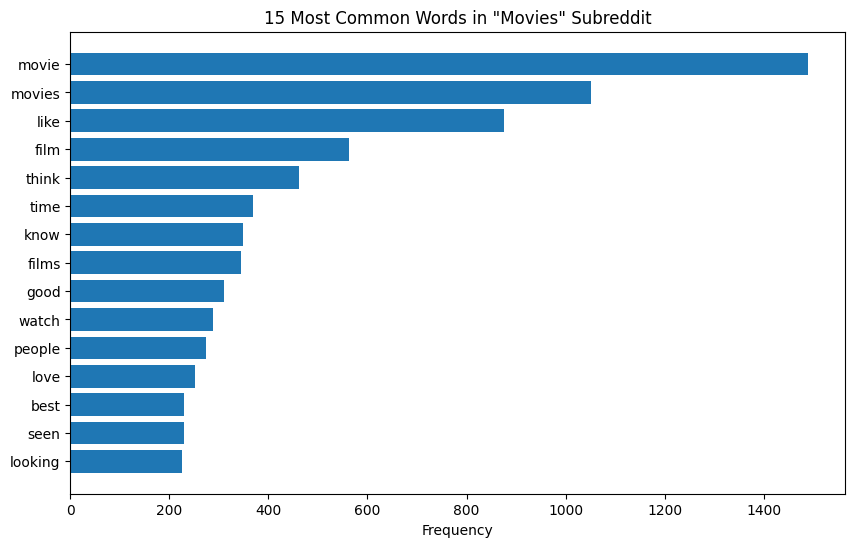

In [ ]:
# 15 most common words for movies subreddit plot
plt.figure(figsize=(10, 6))
plt.barh([word[0] for word in movie_common_words], [word[1] for word in movie_common_words])
plt.title('15 Most Common Words in "Movies" Subreddit')
plt.xlabel('Frequency')
plt.gca().invert_yaxis();

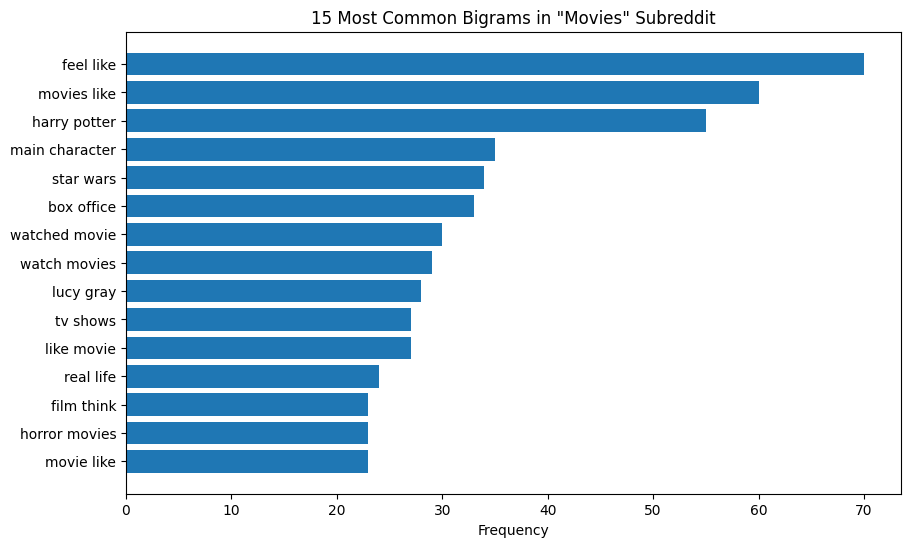

In [ ]:
# 15 most common bigrams for movies subreddit plot
plt.figure(figsize=(10, 6))
plt.barh([bigram[0][0] + ' ' + bigram[0][1] for bigram in movie_common_bigrams], [bigram[1] for bigram in movie_common_bigrams])
plt.title('15 Most Common Bigrams in "Movies" Subreddit')
plt.xlabel('Frequency')
plt.gca().invert_yaxis();

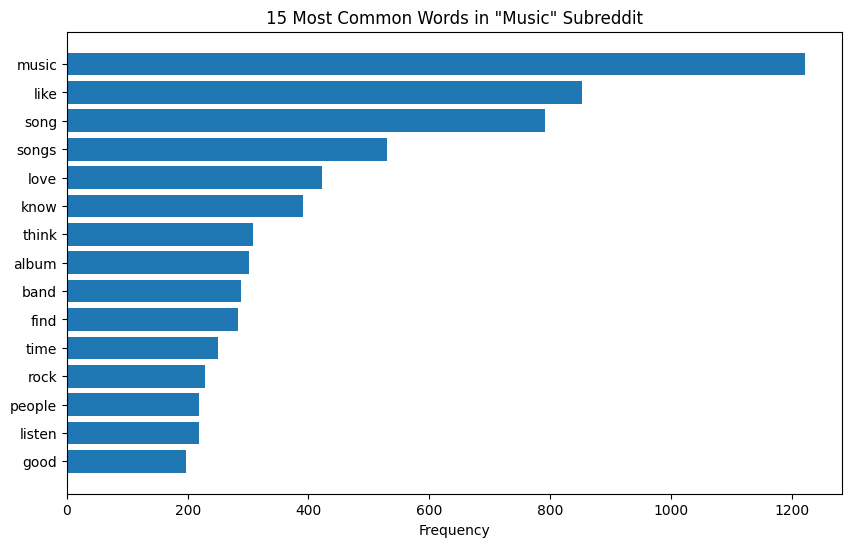

In [ ]:
# 15 most common words for music subreddit plot
plt.figure(figsize=(10, 6))
plt.barh([word[0] for word in music_common_words], [word[1] for word in music_common_words])
plt.title('15 Most Common Words in "Music" Subreddit')
plt.xlabel('Frequency')
plt.gca().invert_yaxis();

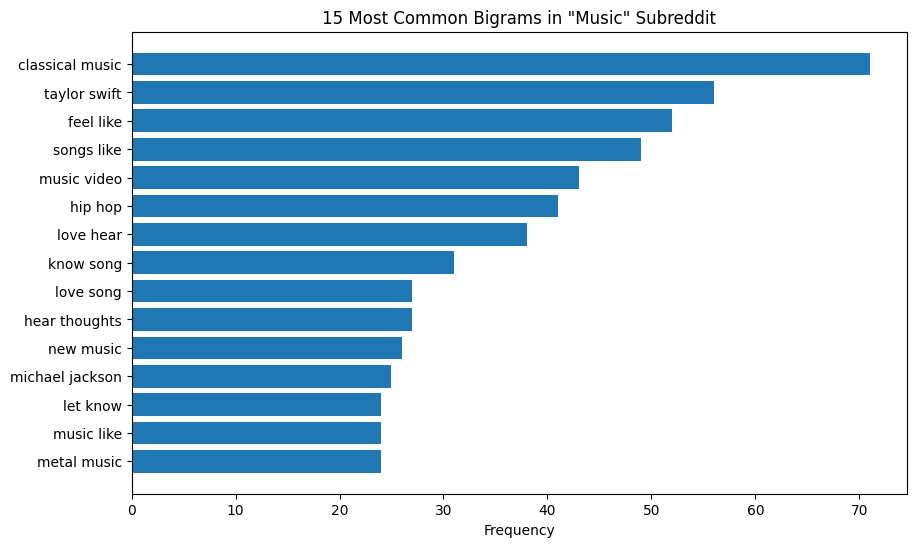

In [ ]:
# 15 most common bigrams for music subreddit plot
plt.figure(figsize=(10, 6))
plt.barh([bigram[0][0] + ' ' + bigram[0][1] for bigram in music_common_bigrams], [bigram[1] for bigram in music_common_bigrams])
plt.title('15 Most Common Bigrams in "Music" Subreddit')
plt.xlabel('Frequency')
plt.gca().invert_yaxis();

In [ ]:
posts = pd.concat([movie, music])

In [ ]:
posts.shape

(2000, 7)

In [ ]:
posts.head()

,author_id,post_id,created_utc,title,self_text,subreddit,clean_post
0,2a05de1,1cd3pko,1.714081e+09,How much longer will Dune 2 be in theaters?,I lost my glasses a couple weeks ago and won’t...,movies,"[longer, dune, theaters, lost, glasses, couple..."
1,w71lonuwc,1cd3p8r,1.714081e+09,where is humane showing?,okay so ive been really excited for humane to ...,movies,"[humane, showing, okay, ve, excited, humane, c..."
2,w3vcatnq,1cd3kpd,1.714081e+09,A Promising Young Woman (Ryan Cooper),I just watched this movie this morning. It was...,movies,"[promising, young, woman, ryan, cooper, watche..."
3,1qu8acfj,1cd2r1s,1.714079e+09,Incident at Haystack Landing (1999 movie),Hello all! I am looking for a movie called Inc...,movies,"[incident, haystack, landing, movie, hello, lo..."
4,xj8fsllj5,1cd2ggf,1.714078e+09,Let's talk about villains that are actually right,"We've seen a lot of movies where the villain, ...",movies,"[let, talk, villains, actually, right, seen, l..."


In [ ]:
posts.isnull().sum()

author_id      8
post_id        0
created_utc    0
title          0
self_text      0
subreddit      0
clean_post     0
dtype: int64

Examine and describe distributions

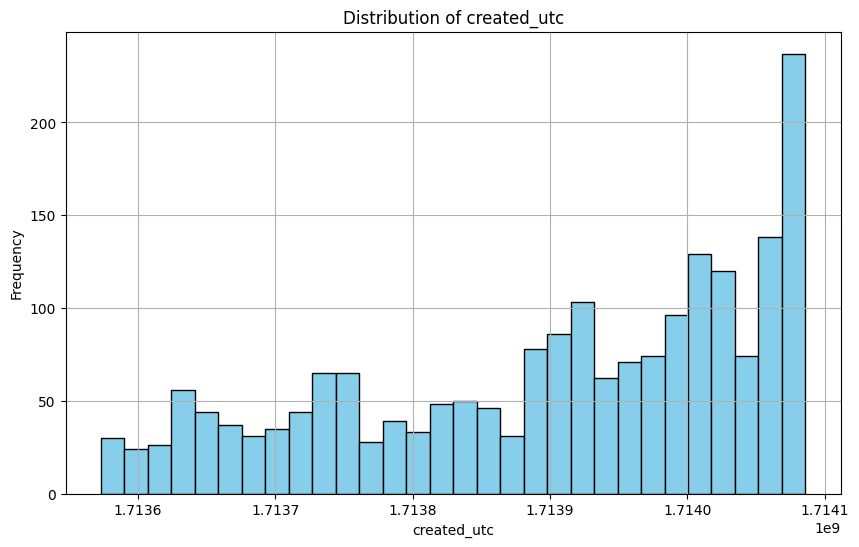

In [ ]:
# Histogram for 'created_utc'
plt.figure(figsize=(10, 6))
plt.hist(posts['created_utc'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of created_utc')
plt.xlabel('created_utc')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [ ]:
posts.describe()

,created_utc
count,2.000000e+03
mean,1.713903e+09
std,1.469632e+05
min,1.713573e+09
25%,1.713785e+09
50%,1.713933e+09
75%,1.714026e+09
max,1.714086e+09



**UTC Timestamp:**

* **1.713573e+09:** `Fri Apr 19 2024 20:30:00 GMT-0400 (Eastern Daylight Time)`
* **1.7136e9:** `Sat Apr 20 2024 04:00:00 GMT-0400 (Eastern Daylight Time)`
* **1.7137e9:** `Sun Apr 21 2024 07:46:40 GMT-0400 (Eastern Daylight Time)`
* **1.7138e9:** `Mon Apr 22 2024 11:33:20 GMT-0400 (Eastern Daylight Time)`
* **1.7139e9:** `Tue Apr 23 2024 15:20:00 GMT-0400 (Eastern Daylight Time)`
* **1.7140e9:** `Wed Apr 24 2024 19:06:40 GMT-0400 (Eastern Daylight Time)`
* **1.714086e+09:** `Thu Apr 25 2024 19:00:00 GMT-0400 (Eastern Daylight Time)`
* **1.7141e9:** `Thu Apr 25 2024 22:53:20 GMT-0400 (Eastern Daylight Time)`

The data collected to build the model consists of Reddit posts posted in interval of time between `Fri Apr 19 2024 20:30:00` and `Thu Apr 25 2024 19:00:00` Eastern Daylight Time.

Conversion from timestamp to timezone: https://www.unixtimestamp.com/

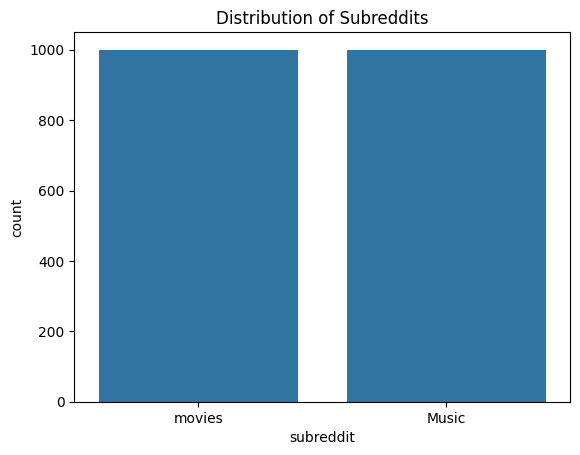

In [ ]:
sns.countplot(x='subreddit', data=posts)
plt.title('Distribution of Subreddits');

New colum `post` that concatenate `title` and `self_text` columns

In [ ]:
posts['post'] = posts['title'] + ' ' + posts['self_text']

In [ ]:
posts.head(2)

,author_id,post_id,created_utc,title,self_text,subreddit,clean_post,post
0,2a05de1,1cd3pko,1.714081e+09,How much longer will Dune 2 be in theaters?,I lost my glasses a couple weeks ago and won’t...,movies,"[longer, dune, theaters, lost, glasses, couple...",How much longer will Dune 2 be in theaters? I ...
1,w71lonuwc,1cd3p8r,1.714081e+09,where is humane showing?,okay so ive been really excited for humane to ...,movies,"[humane, showing, okay, ve, excited, humane, c...",where is humane showing? okay so ive been real...


New columns for `length`, and `word counts` of `post` coumn

In [ ]:
posts['post_length'] = posts['post'].apply(len)

In [ ]:
posts.loc[:, 'post_word_count'] = posts['post'].apply(lambda x: len(x.split()))

In [ ]:
posts.head()

,author_id,post_id,created_utc,title,self_text,subreddit,clean_post,post,post_length,post_word_count
0,2a05de1,1cd3pko,1.714081e+09,How much longer will Dune 2 be in theaters?,I lost my glasses a couple weeks ago and won’t...,movies,"[longer, dune, theaters, lost, glasses, couple...",How much longer will Dune 2 be in theaters? I ...,379,76
1,w71lonuwc,1cd3p8r,1.714081e+09,where is humane showing?,okay so ive been really excited for humane to ...,movies,"[humane, showing, okay, ve, excited, humane, c...",where is humane showing? okay so ive been real...,546,100
2,w3vcatnq,1cd3kpd,1.714081e+09,A Promising Young Woman (Ryan Cooper),I just watched this movie this morning. It was...,movies,"[promising, young, woman, ryan, cooper, watche...",A Promising Young Woman (Ryan Cooper) I just w...,939,175
3,1qu8acfj,1cd2r1s,1.714079e+09,Incident at Haystack Landing (1999 movie),Hello all! I am looking for a movie called Inc...,movies,"[incident, haystack, landing, movie, hello, lo...",Incident at Haystack Landing (1999 movie) Hell...,1134,210
4,xj8fsllj5,1cd2ggf,1.714078e+09,Let's talk about villains that are actually right,"We've seen a lot of movies where the villain, ...",movies,"[let, talk, villains, actually, right, seen, l...",Let's talk about villains that are actually ri...,713,125


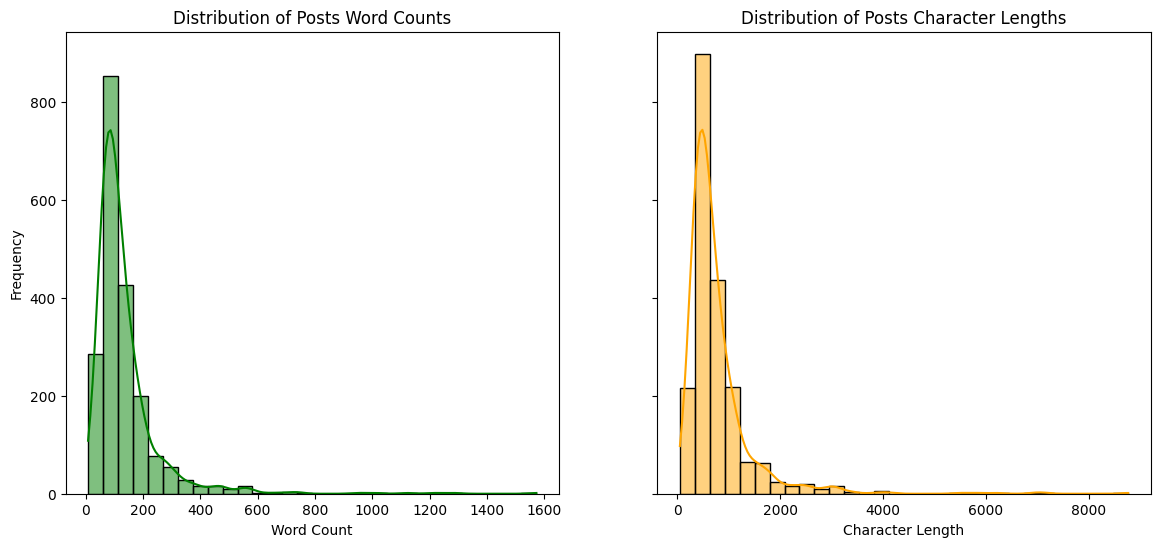

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# distribution of word counts
sns.histplot(posts['post_word_count'], bins=30, ax=axes[0], kde=True, color='green')
axes[0].set_title('Distribution of Posts Word Counts')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

# distribution of character lengths
sns.histplot(posts['post_length'], bins=30, ax=axes[1], kde=True, color='orange')
axes[1].set_title('Distribution of Posts Character Lengths')
axes[1].set_xlabel('Character Length')
axes[1].set_ylabel('Frequency');

In [ ]:
posts['post_length'].mean()

768.498

In [ ]:
posts['post_word_count'].mean()

135.118

In [ ]:
posts['post_length'].std()

708.1778752174299

In [ ]:
posts['post_word_count'].std()

126.15085848121596

How many unique users exist in the dataset?

In [ ]:
unique_users_count = len(posts['author_id'].unique())
print(f'There are {unique_users_count} unique users "author_id" in the dataset.')

There are 763 unique users "author_id" in the dataset.


In [ ]:
users_post = posts['author_id'].value_counts(sort=True).reset_index(name="post_count")
users_post.head(10)

,author_id,post_count
0,r45rhhap,15
1,4s5is,11
2,p4sbp4n8,11
3,euti9dw01,10
4,w8zaruyv,10
5,t6frk88a,10
6,r2uzvfuc,10
7,6b1oto3h,10
8,r2r7v74t,10
9,4qstk8f3,9


In [ ]:
user_post_count = len(users_post[users_post["post_count"] >= 3])
proportion = round(user_post_count/len(users_post)*100, 3)
print(f"There are {user_post_count} users with >= 3 posts in the data sets, which is ~ {proportion}% of total number of users" )

There are 232 users with >= 3 posts in the data sets, which is ~ 30.446% of total number of users


In [ ]:
users_post[users_post["post_count"] >= 3]

,author_id,post_count
0,r45rhhap,15
1,4s5is,11
2,p4sbp4n8,11
3,euti9dw01,10
4,w8zaruyv,10
...,...,...
227,n290e52u,3
228,79wns3z1,3
229,88jjtl3q,3
230,1p3oc0ge,3


The following is to check if post does not contains only stop words, and add a column for the status of this verification

In [ ]:
def contains_only_stop_words(text):
    '''
    Function to check if all tokens in text are stop words
    '''
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
    if all(token in nlp.Defaults.stop_words for token in tokens):
        return True
    return False

In [ ]:
posts.loc[:, 'contains_only_stop_words'] = posts['post'].apply(contains_only_stop_words)

posts[posts['contains_only_stop_words']]

,author_id,post_id,created_utc,title,self_text,subreddit,clean_post,post,post_length,post_word_count,contains_only_stop_words


**There no post containing only stop words**

In [ ]:
posts.head()

,author_id,post_id,created_utc,title,self_text,subreddit,clean_post,post,post_length,post_word_count,contains_only_stop_words
0,2a05de1,1cd3pko,1.714081e+09,How much longer will Dune 2 be in theaters?,I lost my glasses a couple weeks ago and won’t...,movies,"[longer, dune, theaters, lost, glasses, couple...",How much longer will Dune 2 be in theaters? I ...,379,76,False
1,w71lonuwc,1cd3p8r,1.714081e+09,where is humane showing?,okay so ive been really excited for humane to ...,movies,"[humane, showing, okay, ve, excited, humane, c...",where is humane showing? okay so ive been real...,546,100,False
2,w3vcatnq,1cd3kpd,1.714081e+09,A Promising Young Woman (Ryan Cooper),I just watched this movie this morning. It was...,movies,"[promising, young, woman, ryan, cooper, watche...",A Promising Young Woman (Ryan Cooper) I just w...,939,175,False
3,1qu8acfj,1cd2r1s,1.714079e+09,Incident at Haystack Landing (1999 movie),Hello all! I am looking for a movie called Inc...,movies,"[incident, haystack, landing, movie, hello, lo...",Incident at Haystack Landing (1999 movie) Hell...,1134,210,False
4,xj8fsllj5,1cd2ggf,1.714078e+09,Let's talk about villains that are actually right,"We've seen a lot of movies where the villain, ...",movies,"[let, talk, villains, actually, right, seen, l...",Let's talk about villains that are actually ri...,713,125,False


In [ ]:
posts.describe()

,created_utc,post_length,post_word_count
count,2.000000e+03,2000.000000,2000.000000
mean,1.713903e+09,768.498000,135.118000
std,1.469632e+05,708.177875,126.150858
min,1.713573e+09,49.000000,8.000000
25%,1.713785e+09,402.000000,72.000000
50%,1.713933e+09,573.000000,101.000000
75%,1.714026e+09,863.250000,151.250000
max,1.714086e+09,8765.000000,1573.000000


Ref. code for the following cell: https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524

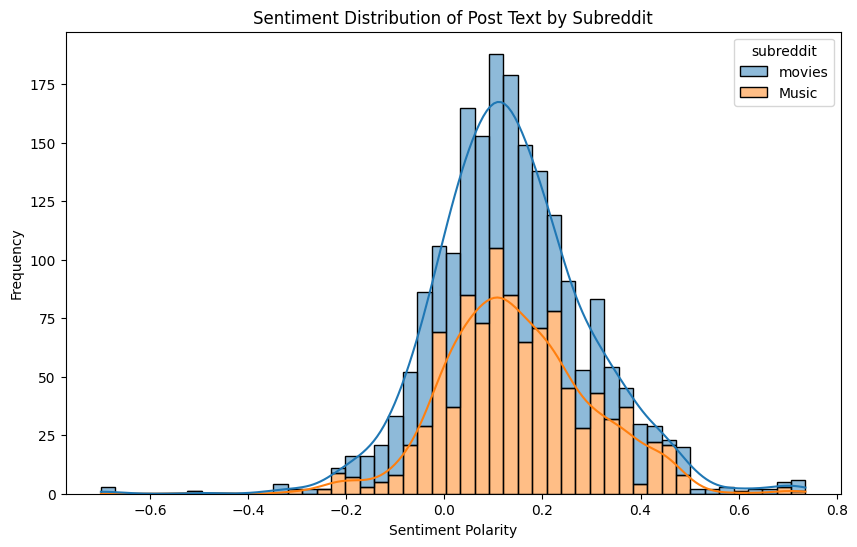

In [ ]:
def calculate_sentiment(text):
    '''
    This function calculates sentiment polarity
    '''
    blob = TextBlob(text)
    return blob.sentiment.polarity

# apply sentiment analysis to the post
posts['post_sentiment'] = posts['post'].apply(calculate_sentiment)

# Compare sentiment distributions by subreddit
plt.figure(figsize=(10, 6))
sns.histplot(data=posts, x='post_sentiment', hue='subreddit', multiple='stack', kde=True)
plt.title('Sentiment Distribution of Post Text by Subreddit')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency');

Sentiment polarity measures the emotional tone of text, showing if it's positive, negative, or neutral. Positive polarity means happy or satisfied language, negative is sad or dissatisfied, and zero is neutral with no strong emotion. Analyzing sentiment helps understand the overall mood and feelings expressed in text for gauging attitudes, opinions, and emotions in posts.

Ref. code for the following two cells: https://blog.mlreview.com/topic-modeling-with-scikit-learn-e80d33668730

This following is to find common topics within text data. It converts the text into numbers using CountVectorizer and then applies the `Latent Dirichlet Allocation (LDA)` method to identify underlying topics. The `display_topics_lda` function shows the main words associated with each topic, revealing the key ideas discussed in the text. This helps to understand what the text is generally about and discover important patterns or themes.

In [ ]:
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
posts_data = vectorizer.fit_transform(posts['post'])

lda = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online', learning_offset=50.,random_state=42).fit(posts_data)

feature_names = vectorizer.get_feature_names_out()

def display_topics_lda(model, feature_names, n_top_words):
    '''
    This function displays top words per topic for LDA
    '''
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

display_topics_lda(lda, feature_names, n_top_words=10)

Topic 1:
movie like movies just music film harry watch life potter
Topic 2:
best johnny cash live blanchett performance june opinion artist greatest
Topic 3:
https com youtube www music si watch song listen youtu
Topic 4:
music like songs song think just movies movie hate lyrics
Topic 5:
band rock music help video song boy like songs remember
Topic 6:
like movie just movies know think music song don really
Topic 7:
song bass band guitar sound x200b playing songs way car
Topic 8:
music classical artists don artist looking popular love just aspect
Topic 9:
album like spotify albums really band favorite bands time 1k
Topic 10:
love metal singing rock music girl john song style una


The following is also to find common topics within text data using a different method `Non-Negative Matrix Factorization (NMF)`.

In [ ]:
nmf = NMF(n_components=10, random_state=42, init='nndsvd').fit(posts_data)

feature_names = vectorizer.get_feature_names_out()

def display_topics_nmf(model, feature_names, n_top_words):
    '''
    This function displays top words per topic for NMF
    '''
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

display_topics_nmf(nmf, feature_names, n_top_words=10)


Topic 1:
movie movies like just know ve really think don watch
Topic 2:
love girl rock song just heart heavy quite kiss great
Topic 3:
music like just classical people think don need let different
Topic 4:
leonard think teddy time know theory don movie wife sammy
Topic 5:
song band songs bass like playing ve sound really way
Topic 6:
harry potter movie fans film beasts rowling franchise fantastic story
Topic 7:
boys like sisters girls did parents lux actually trip didn
Topic 8:
films film mind changed watch directors time great cinema best
Topic 9:
snow lucy gray movie end people gaul coryo snows film
Topic 10:
blanchett cate cast role movie robbed drop dropped replaced acting


Ref. code for the following cell: https://www.datacamp.com/tutorial/wordcloud-python

The following two plots creates a visual representation of the most frequent words found in posts from a the `movies` and `music` subreddits. The size of each word reflects its frequency in the text, larger words appear more often.

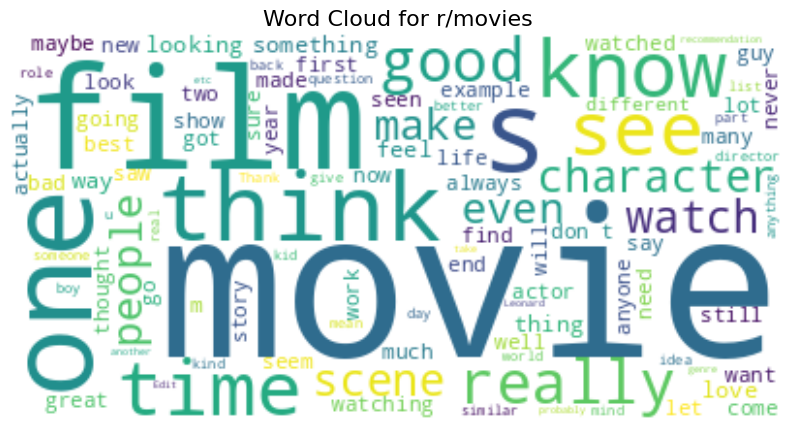

In [ ]:
def generate_word_cloud(subreddit_name):
    '''
    This function generates word cloud for a specific subreddit
    '''
    text = " ".join(post for post in posts[posts['subreddit'] == subreddit_name]['post'])
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for r/{subreddit_name}", fontsize=16);

generate_word_cloud('movies') # word cloud for 'movies' subreddit

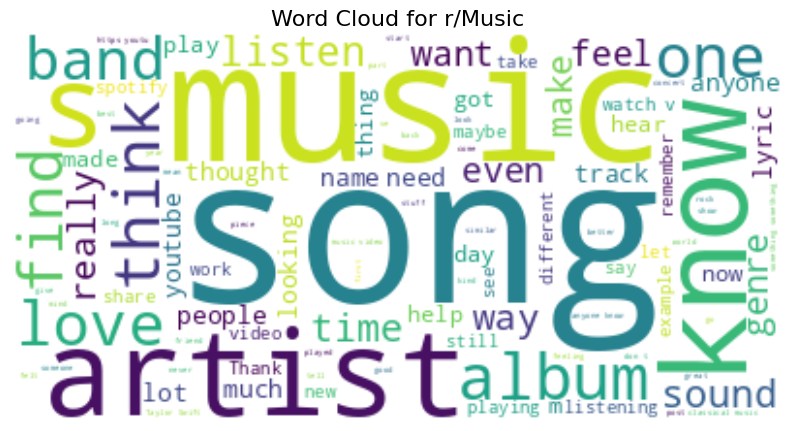

In [ ]:
generate_word_cloud('Music') # word cloud for 'music' subreddit

# Preprocessing and Modeling

In [ ]:
# Reload spaCy model and disable unnecessary components for faster processing when training the model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(text):
    '''
    This function is to lemmatized text using spaCy
    '''
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc if not token.is_stop])  # Lemmatize and remove stop words
    return lemmatized_text

In [ ]:
X = posts['title'] + ' ' + posts['self_text'] # features
y = posts['subreddit'].map({'Music':0, 'movies':1}) # binary label

In [ ]:
X_preprocessed = X.apply(lemmatize) # lemmatize the text data (title + self_text)

In [ ]:
X

0      How much longer will Dune 2 be in theaters? I ...
1      where is humane showing? okay so ive been real...
2      A Promising Young Woman (Ryan Cooper) I just w...
3      Incident at Haystack Landing (1999 movie) Hell...
4      Let's talk about villains that are actually ri...
                             ...                        
995    Favorite band with fewer than 1,000 monthly li...
996    Could you recommend some songs that are in the...
997    Favorite band with fewer than 1,000 monthly li...
998    Favorite band with fewer than 1,000 monthly li...
999    Favorite band with fewer than 1,000 monthly li...
Length: 2000, dtype: object

In [ ]:
X_preprocessed

0      long Dune 2 theater ? lose glass couple week a...
1      humane showing ? okay ve excited humane come c...
2      promise Young Woman ( Ryan Cooper ) watch movi...
3      incident Haystack Landing ( 1999 movie ) hello...
4      let talk villain actually right see lot movie ...
                             ...                        
995    favorite band few 1,000 monthly listener Spoti...
996    recommend song theme " " similar " black " -AC...
997    favorite band few 1,000 monthly listener Spoti...
998    favorite band few 1,000 monthly listener Spoti...
999    favorite band few 1,000 monthly listener Spoti...
Length: 2000, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, stratify = y, test_size=0.2, random_state=42)

In [ ]:
# Pipelines
# Logistic Regression
cvect_logreg = Pipeline([
    ('cvect', CountVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LogisticRegression(max_iter=10000, solver='saga'))
])

tfidf_logreg = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LogisticRegression(max_iter=10000, solver='saga'))
])

# Naive Bayes
cvect_nb = Pipeline([
    ('cvect', CountVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', MultinomialNB())
])

tfidf_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', MultinomialNB())
])

# Random Forest Classifier
rf_cvect = Pipeline([
    ('cvect', CountVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', RandomForestClassifier())
])

rf_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', RandomForestClassifier())
])

# XGBoost Classifier
xgb_cvect = Pipeline([
    ('cvect', CountVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', XGBClassifier())
])

xgb_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', XGBClassifier())
])


In [ ]:
# parameter grids for GridSearchCV
# Logistic Regression
param_grid_cvect_logreg = {
    'cvect__stop_words': ['english'],
    'cvect__max_features': [500, 1000, 2000, 5000],
    'cvect__ngram_range': [(1, 1), (1, 2), (2,2)],
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2']  # Add penalty options (L1 or L2)
}

param_grid_tfidf_logreg = {
    'tfidf__stop_words': ['english'],
    'tfidf__max_features': [500, 1000, 2000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2,2)],
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2']  # Add penalty options (L1 or L2)
}

# Naive Bayes
param_grid_cvect_nb = {
    'cvect__stop_words': ['english'],
    'cvect__max_features': [500, 1000, 2000, 5000],
    'cvect__ngram_range': [(1, 1), (1, 2), (2,2)],
    'model__alpha': [ 0.01, 0.1, 0.5, 1.0]
}

param_grid_nb_tfidf = {
    'tfidf__stop_words': ['english'],
    'tfidf__max_features': [500, 1000, 2000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2,2)],
    'model__alpha': [ 0.01, 0.1, 0.5, 1.0]
}

# Random Forest Classifier
param_grid_rf_cvect = {
    'cvect__stop_words': ['english'],
    'cvect__max_features': [500, 1000, 2000, 5000],
    'cvect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20]
}

param_grid_rf_tfidf = {
    'tfidf__stop_words': ['english'],
    'tfidf__max_features': [500, 1000, 2000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20]
}

# XGBoost Classifier
param_grid_xgb_tfidf = {
    'tfidf__stop_words': ['english'],
    'tfidf__max_features': [500, 1000, 2000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1, 0.2]
}

param_grid_xgb_cvect = {
    'cvect__stop_words': ['english'],
    'cvect__max_features': [500, 1000, 2000, 5000],
    'cvect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1, 0.2]
}

In [ ]:
# GridSearchCV for CountVectorizer + Logistic Regression pipeline
grid_search_cvect_logreg = GridSearchCV(cvect_logreg, param_grid_cvect_logreg, cv=5)
grid_search_cvect_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvect', CountVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           solver='saga'))]),
             param_grid={'cvect__max_features': [500, 1000, 2000, 5000],
                         'cvect__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvect__stop_words': ['english'],
                         'model__C': [0.01, 0.1, 1, 10],
                         'model__penalty': ['l1', 'l2']})

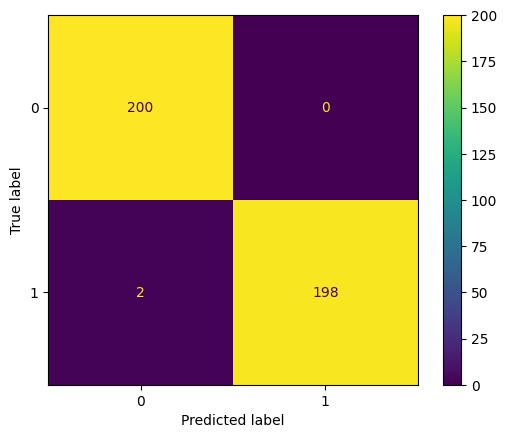

In [ ]:
# Confusion matrix for CountVectorizer + Logistic Regression
y_pred_cvect_logreg = grid_search_cvect_logreg.predict(X_test)
cm_cvect_logreg = confusion_matrix(y_test, y_pred_cvect_logreg)
disp_cvect_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_cvect_logreg, display_labels=grid_search_cvect_logreg.classes_)
disp_cvect_logreg.plot()

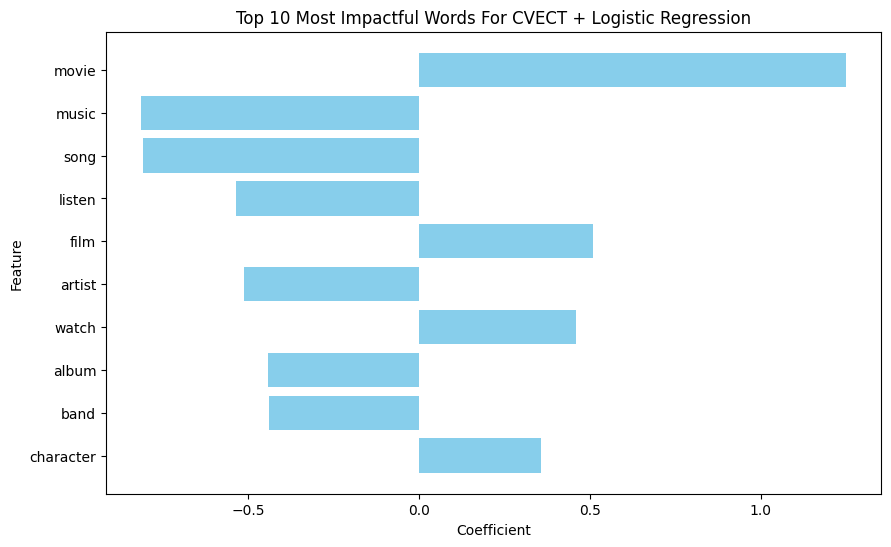

In [ ]:
# retrieve the best model from GridSearchCV
best_cvect_logreg_model = grid_search_cvect_logreg.best_estimator_

# retrieve coefficients from the best model
coefficients_cvect_logreg = best_cvect_logreg_model.named_steps['model'].coef_[0]

# feature names
feature_names_cvect_logreg = best_cvect_logreg_model.named_steps['cvect'].get_feature_names_out()

# create df for features and coefficients
coef_df_cvect_logreg = pd.DataFrame({'Feature': feature_names_cvect_logreg, 'Coefficient': coefficients_cvect_logreg})

# sort df by absolute coefficient value
sorted_features_cvect_logreg = coef_df_cvect_logreg.sort_values(by='Coefficient', key=abs, ascending=False)

# top 10 most important features
top_10_features_cvect_logreg = sorted_features_cvect_logreg.head(10)

# top 10 most important features plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_features_cvect_logreg['Feature'], top_10_features_cvect_logreg['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 10 Most Impactful Words For CVECT + Logistic Regression')
plt.gca().invert_yaxis();

In [ ]:
# GridSearchCV for TfidfVectorizer + Logistic Regression pipeline
grid_search_tfidf_logreg = GridSearchCV(tfidf_logreg, param_grid_tfidf_logreg, cv=5)
grid_search_tfidf_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           solver='saga'))]),
             param_grid={'model__C': [0.01, 0.1, 1, 10],
                         'model__penalty': ['l1', 'l2'],
                         'tfidf__max_features': [500, 1000, 2000, 5000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tfidf__stop_words': ['english']})

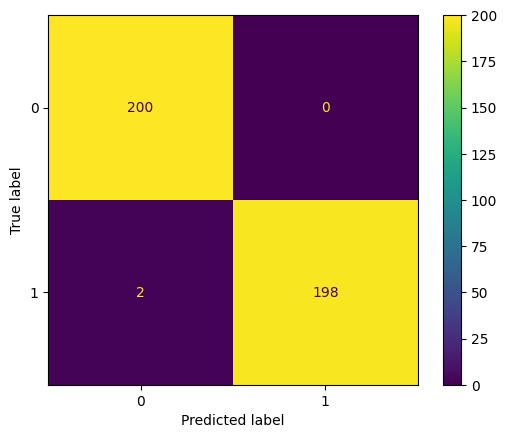

In [ ]:
# confusion matrix for TfidfVectorizer + Logistic Regression
y_pred_tfidf_logreg = grid_search_tfidf_logreg.predict(X_test)
cm_tfidf_logreg = confusion_matrix(y_test, y_pred_tfidf_logreg)
disp_tfidf_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf_logreg, display_labels=grid_search_tfidf_logreg.classes_)
disp_tfidf_logreg.plot()

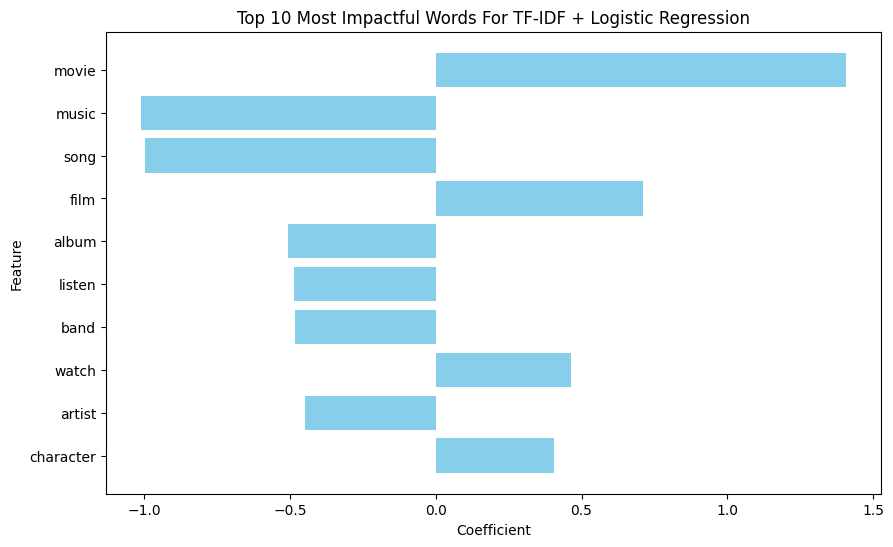

In [ ]:
# retrieve the best model from GridSearchCV
best_tfidf_logreg_model = grid_search_cvect_logreg.best_estimator_

# retrieve coefficients from the best model
coefficients_tfidf_logreg = best_tfidf_logreg_model.named_steps['model'].coef_[0]

# feature names
feature_names_tfidf_logreg = best_tfidf_logreg_model.named_steps['tfidf'].get_feature_names_out()

# create df for features and coefficients
coef_df_tfidf_logreg = pd.DataFrame({'Feature': feature_names_tfidf_logreg, 'Coefficient': coefficients_tfidf_logreg})

# sort df by absolute coefficient value
sorted_features_tfidf_logreg = coef_df_tfidf_logreg.sort_values(by='Coefficient', key=abs, ascending=False)

# top 10 most important features
top_10_features_tfidf_logreg = sorted_features_tfidf_logreg.head(10)

# top 10 most important features plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_features_tfidf_logreg['Feature'], top_10_features_tfidf_logreg['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 10 Most Impactful Words For TF-IDF + Logistic Regression')
plt.gca().invert_yaxis();


In [ ]:
# GridSearchCV for CountVectorizer + MultinomialNB pipeline
grid_search_cvect_nb = GridSearchCV(cvect_nb, param_grid_cvect_nb, cv=5)
grid_search_cvect_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvect', CountVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', MultinomialNB())]),
             param_grid={'cvect__max_features': [500, 1000, 2000, 5000],
                         'cvect__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvect__stop_words': ['english'],
                         'model__alpha': [0.01, 0.1, 0.5, 1.0]})

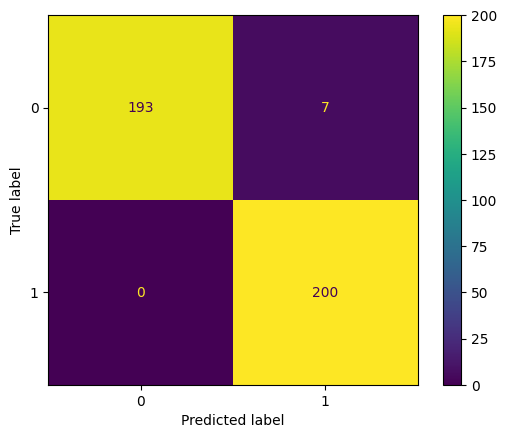

In [ ]:
# Confusion matrix for CountVectorizer + MultinomialNB
y_pred_cvect_nb = grid_search_cvect_nb.predict(X_test)
cm_cvect_nb = confusion_matrix(y_test, y_pred_cvect_nb)
disp_cvect_nb = ConfusionMatrixDisplay(confusion_matrix=cm_cvect_nb, display_labels=grid_search_cvect_nb.classes_)
disp_cvect_nb.plot()

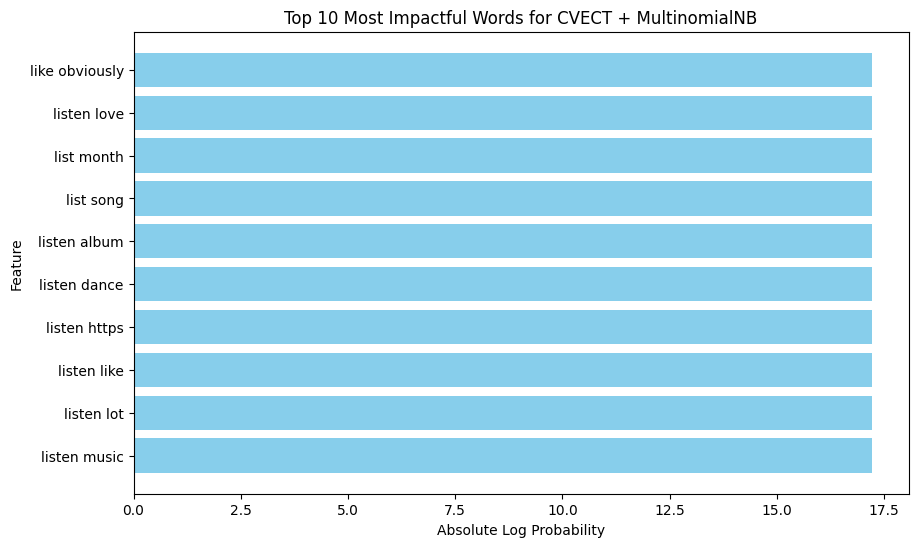

In [ ]:
# retrieve the best estimator from the grid search
best_cvect_nb_model = grid_search_cvect_nb.best_estimator_

# retrieve feature log probabilities from the best model
feature_log_probabilities_cvect_nb = best_cvect_nb_model.named_steps['model'].feature_log_prob_

# feature names
feature_names_cvect_nb = best_cvect_nb_model.named_steps['cvect'].get_feature_names_out()

# create df for features and coefficients
coef_df_cvect_nb = pd.DataFrame({'Feature': feature_names_cvect_nb, 'Coefficient': feature_log_probabilities_cvect_nb[1]})  # Assuming binary classification, using coefficients for class 1

# take the absolute values of the coefficients for sorting
coef_df_cvect_nb['Coefficient'] = np.abs(coef_df_cvect_nb['Coefficient'])

# sort df by absolute coefficient value
sorted_features_cvect_nb = coef_df_cvect_nb.sort_values(by='Coefficient', ascending=False)

# top 10 most important features
top_10_features_cvect_nb = sorted_features_cvect_nb.head(10)

# top 10 most important features plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_features_cvect_nb['Feature'], top_10_features_cvect_nb['Coefficient'], color='skyblue')
plt.xlabel('Absolute Log Probability')
plt.ylabel('Feature')
plt.title('Top 10 Most Impactful Words for CVECT + MultinomialNB')
plt.gca().invert_yaxis();


In [ ]:
# GridSearchCV for TfidfVectorizer + MultinomialNB pipeline
grid_search_tfidf_nb = GridSearchCV(tfidf_nb, param_grid_nb_tfidf, cv=5)
grid_search_tfidf_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', MultinomialNB())]),
             param_grid={'model__alpha': [0.01, 0.1, 0.5, 1.0],
                         'tfidf__max_features': [500, 1000, 2000, 5000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tfidf__stop_words': ['english']})

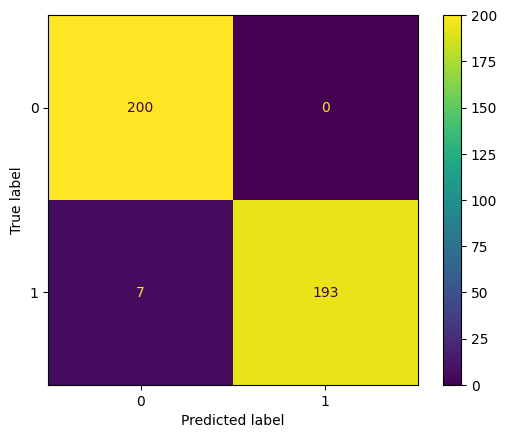

In [ ]:
# Confusion matrix for TfidfVectorizer + MultinomialNB
y_pred_tfidf_nb = grid_search_tfidf_nb.predict(X_test)
cm_tfidf_nb = confusion_matrix(y_test, y_pred_tfidf_nb)
disp_tfidf_nb = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf_nb, display_labels=grid_search_tfidf_nb.classes_)
disp_tfidf_nb.plot()

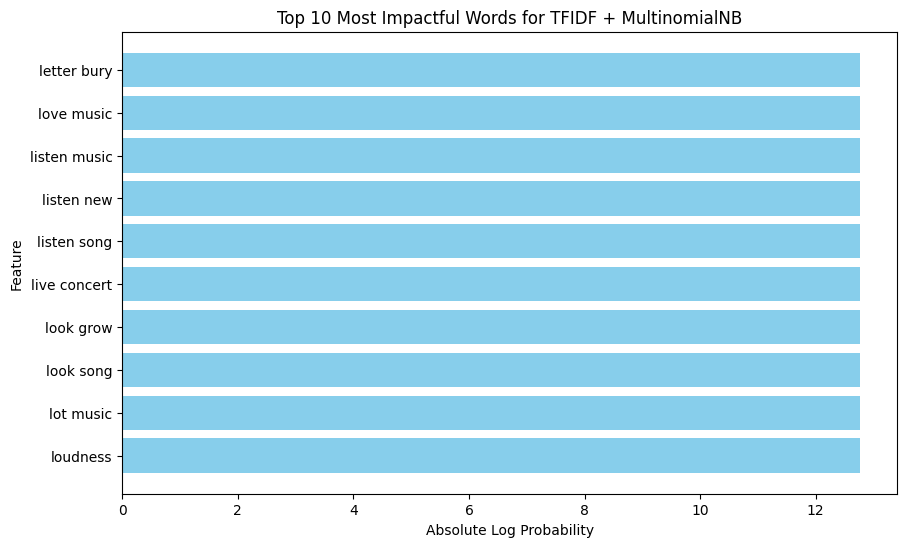

In [ ]:
# retrieve the best estimator from the grid search
best_tfidf_nb_model = grid_search_tfidf_nb.best_estimator_

# retrieve feature log probabilities from the best model
feature_log_probabilities_tfidf_nb = best_tfidf_nb_model.named_steps['model'].feature_log_prob_

# feature names
feature_names_tfidf_nb = best_tfidf_nb_model.named_steps['tfidf'].get_feature_names_out()

# create df for features and coefficients
coef_df_tfidf_nb = pd.DataFrame({'Feature': feature_names_tfidf_nb, 'Coefficient': feature_log_probabilities_tfidf_nb[1]})  # Assuming binary classification, using coefficients for class 1

# absolute values of the coefficients for sorting
coef_df_tfidf_nb['Coefficient'] = np.abs(coef_df_tfidf_nb['Coefficient'])

# sort df by absolute coefficient value
sorted_features_tfidf_nb = coef_df_tfidf_nb.sort_values(by='Coefficient', ascending=False)

# top 10 most important features
top_10_features_tfidf_nb = sorted_features_tfidf_nb.head(10)

# top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features_tfidf_nb['Feature'], top_10_features_tfidf_nb['Coefficient'], color='skyblue')
plt.xlabel('Absolute Log Probability')
plt.ylabel('Feature')
plt.title('Top 10 Most Impactful Words for TFIDF + MultinomialNB')
plt.gca().invert_yaxis();

In [ ]:
# GridSearchCV for CountVectorizer + RandomForestClassifier pipeline
grid_search_rf_cvect = GridSearchCV(rf_cvect, param_grid_rf_cvect, cv=5)
grid_search_rf_cvect.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvect', CountVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', RandomForestClassifier())]),
             param_grid={'cvect__max_features': [500, 1000, 2000, 5000],
                         'cvect__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvect__stop_words': ['english'],
                         'model__max_depth': [None, 10, 20],
                         'model__n_estimators': [100, 200, 300]})

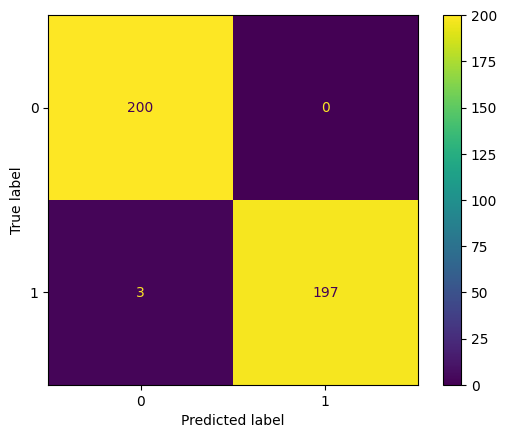

In [ ]:
# Confusion matrix for CountVectorizer + RandomForestClassifier
y_pred_rf_cvect = grid_search_rf_cvect.predict(X_test)
cm_rf_cvect = confusion_matrix(y_test, y_pred_rf_cvect)
disp_rf_cvect = ConfusionMatrixDisplay(confusion_matrix=cm_rf_cvect, display_labels=grid_search_rf_cvect.classes_)
disp_rf_cvect.plot()

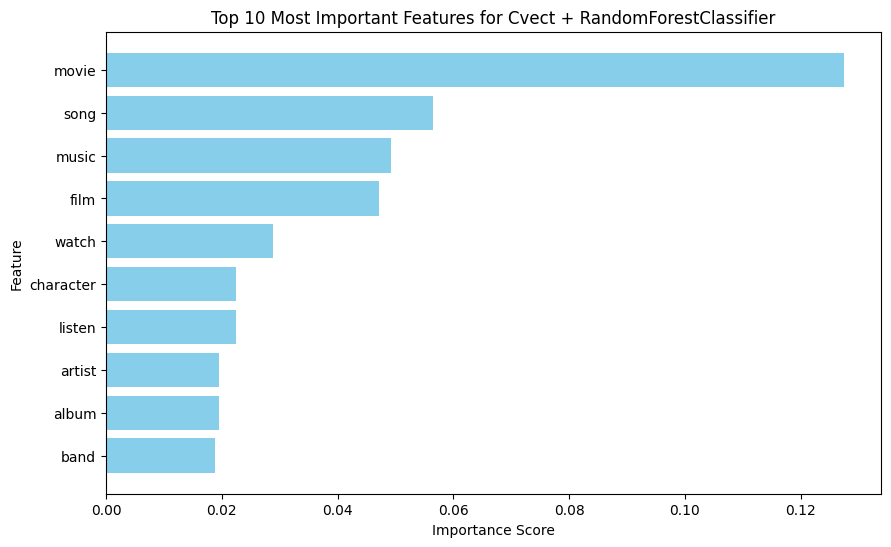

In [ ]:
# best estimator from grid search for CountVectorizer + RandomForestClassifier
best_rf_cvect_model = grid_search_rf_cvect.best_estimator_

# Importance scores
feature_importances_rf_cvect = best_rf_cvect_model.named_steps['model'].feature_importances_

# feature names
feature_names_rf_cvect = best_rf_cvect_model.named_steps['cvect'].get_feature_names_out()

# Create df for features and importance scores
importance_df_rf_cvect = pd.DataFrame({'Feature': feature_names_rf_cvect, 'Importance': feature_importances_rf_cvect})

# sort df by importance scores in descending order
sorted_features_rf_cvect = importance_df_rf_cvect.sort_values(by='Importance', ascending=False)

# top 10 most important features
top_10_features_rf_cvect = sorted_features_rf_cvect.head(10)

# top 10 most important features (Feature and Importance)
top_10_most_important_rf_cvect = top_10_features_rf_cvect[['Feature', 'Importance']]

# top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(top_10_most_important_rf_cvect['Feature'], top_10_most_important_rf_cvect['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features for Cvect + RandomForestClassifier')
plt.gca().invert_yaxis();

In [ ]:
# GridSearchCV for TfidfVectorizer + RandomForestClassifier pipeline
grid_search_rf_tfidf = GridSearchCV(rf_tfidf, param_grid_rf_tfidf, cv=5)
grid_search_rf_tfidf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__n_estimators': [100, 200, 300],
                         'tfidf__max_features': [500, 1000, 2000, 5000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tfidf__stop_words': ['english']})

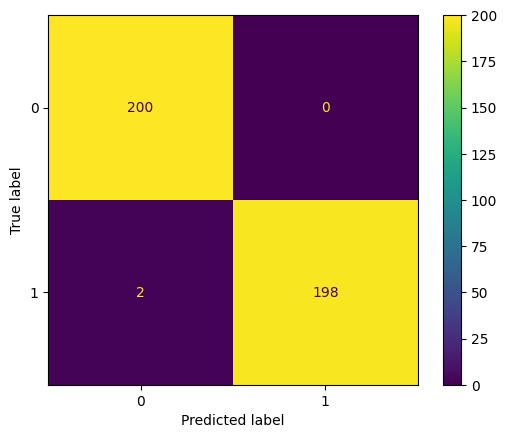

In [ ]:
# Confusion matrix for TfidfVectorizer + RandomForestClassifier
y_pred_rf_tfidf = grid_search_rf_tfidf.predict(X_test)
cm_rf_tfidf = confusion_matrix(y_test, y_pred_rf_tfidf)
disp_rf_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tfidf, display_labels=grid_search_rf_tfidf.classes_)
disp_rf_tfidf.plot()

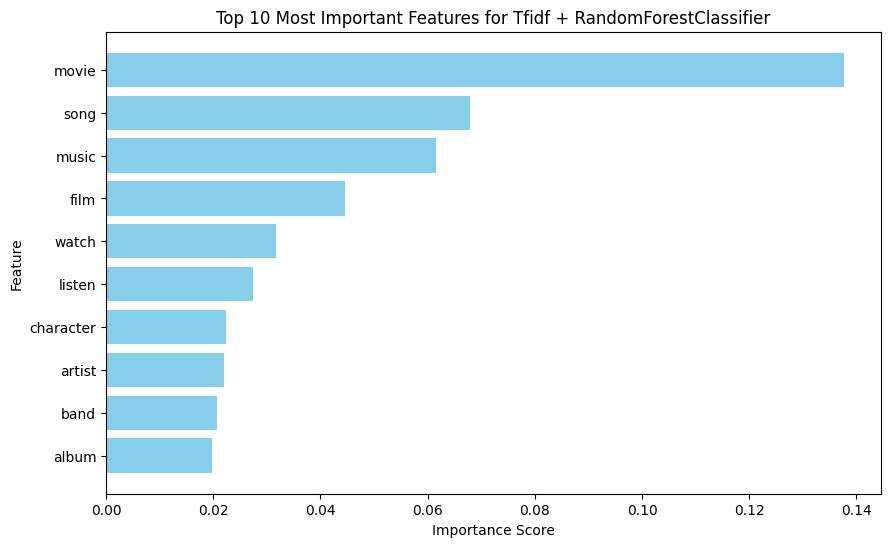

In [ ]:
# best estimator from grid search for CountVectorizer + RandomForestClassifier
best_rf_tfidf_model = grid_search_rf_tfidf.best_estimator_

# importance scores
feature_importances_rf_tfidf = best_rf_tfidf_model.named_steps['model'].feature_importances_

# feature names
feature_names_rf_tfidf = best_rf_tfidf_model.named_steps['tfidf'].get_feature_names_out()

# create df for features and importance scores
importance_df_rf_tfidf = pd.DataFrame({'Feature': feature_names_rf_tfidf, 'Importance': feature_importances_rf_tfidf})

# sort df by importance scores in descending order
sorted_features_rf_tfidf = importance_df_rf_tfidf.sort_values(by='Importance', ascending=False)

# top 10 most important features
top_10_features_rf_tfidf = sorted_features_rf_tfidf.head(10)

# top 10 most important features (Feature and Importance)
top_10_most_important_rf_tfidf = top_10_features_rf_tfidf[['Feature', 'Importance']]

# top 10 most important features plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_most_important_rf_tfidf['Feature'], top_10_most_important_rf_tfidf['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features for Tfidf + RandomForestClassifier')
plt.gca().invert_yaxis();

In [ ]:
# GridSearchCV for CountVectorizer + XGBoostClassifier pipeline
grid_search_xgb_cvect = GridSearchCV(xgb_cvect, param_grid_xgb_cvect, cv=5)
grid_search_xgb_cvect.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvect', CountVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      g...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'cvect__max_features': [500, 1000, 2000, 5000],
                         'cvect__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvect__stop_words': ['english'],
                         'model__learning_rate': [0.05, 0.1, 0.2],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 200, 300]})

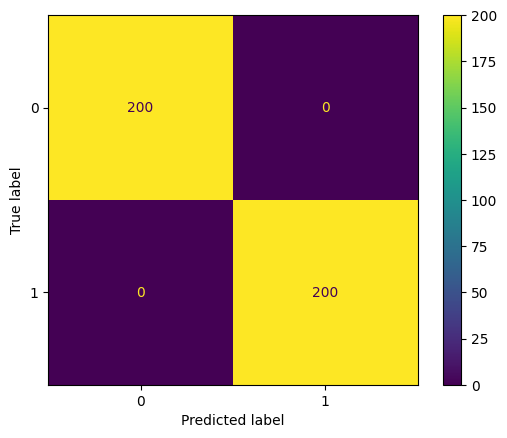

In [ ]:
# Confusion matrix for CountVectorizer + XGBoostClassifier
y_pred_xgb_cvect = grid_search_xgb_cvect.predict(X_test)
cm_xgb_cvect = confusion_matrix(y_test, y_pred_xgb_cvect)
disp_xgb_cvect = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_cvect, display_labels=grid_search_xgb_cvect.classes_)
disp_xgb_cvect.plot()

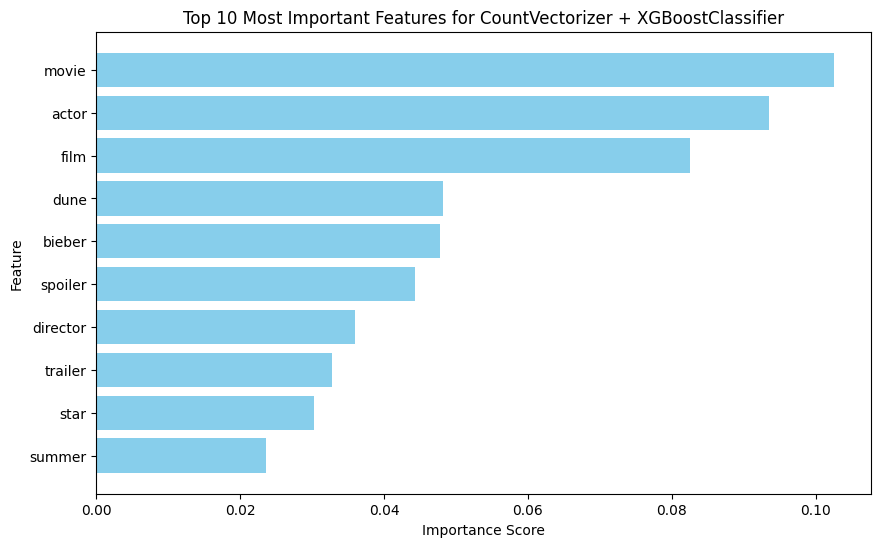

In [ ]:
# best estimator from grid search for CountVectorizer + XGBoostClassifier
best_xgb_cvect_model = grid_search_xgb_cvect.best_estimator_

# importance scores
feature_importances_xgb_cvect = best_xgb_cvect_model['model'].feature_importances_

# feature names
feature_names_xgb_cvect = best_xgb_cvect_model.named_steps['cvect'].get_feature_names_out()

# df for features and importance scores
importance_df_xgb_cvect = pd.DataFrame({'Feature': feature_names_xgb_cvect, 'Importance': feature_importances_xgb_cvect})

# sort df by importance scores in descending order
sorted_features_xgb_cvect = importance_df_xgb_cvect.sort_values(by='Importance', ascending=False)

# top 10 most important features
top_10_features_xgb_cvect = sorted_features_xgb_cvect.head(10)

# top 10 most important features (Feature and Importance)
top_10_most_important_xgb_cvect = top_10_features_xgb_cvect[['Feature', 'Importance']]

# top 10 most important features plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_most_important_xgb_cvect['Feature'], top_10_most_important_xgb_cvect['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features for CountVectorizer + XGBoostClassifier')
plt.gca().invert_yaxis();

In [ ]:
# GridSearchCV for TfidfVectorizer + XGBoostClassifier pipeline
grid_search_xgb_tfidf = GridSearchCV(xgb_tfidf, param_grid_xgb_tfidf, cv=5)
grid_search_xgb_tfidf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      g...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'model__learning_rate': [0.05, 0.1, 0.2],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 200, 300],
                         'tfidf__max_features': [500, 1000, 2000, 5000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tfidf__stop_words': ['english']})

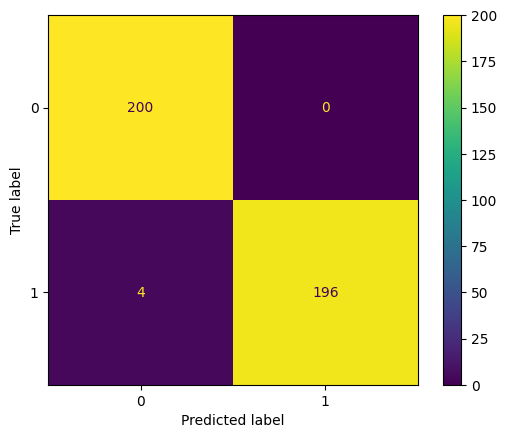

In [ ]:
# Confusion matrix for TfidfVectorizer + XGBoostClassifier
y_pred_xgb_tfidf = grid_search_xgb_tfidf.predict(X_test)
cm_xgb_tfidf = confusion_matrix(y_test, y_pred_xgb_tfidf)
disp_xgb_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_tfidf, display_labels=grid_search_xgb_tfidf.classes_)
disp_xgb_tfidf.plot()

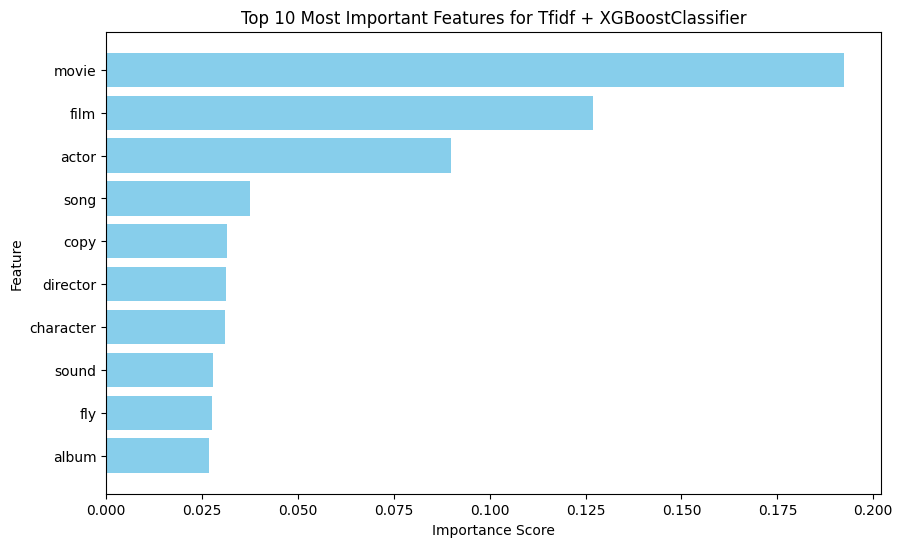

In [ ]:
# best estimator from grid search for CountVectorizer + XGBoostClassifier
best_xgb_tfidf_model = grid_search_xgb_tfidf.best_estimator_

# importance scores
feature_importances_xgb_tfidf = best_xgb_tfidf_model['model'].feature_importances_

# feature names
feature_names_xgb_tfidf = best_xgb_tfidf_model.named_steps['tfidf'].get_feature_names_out()

# df for features and importance scores
importance_df_xgb_tfidf = pd.DataFrame({'Feature': feature_names_xgb_tfidf, 'Importance': feature_importances_xgb_tfidf})

# sort df by importance scores in descending order
sorted_features_xgb_tfidf = importance_df_xgb_tfidf.sort_values(by='Importance', ascending=False)

# top 10 most important features
top_10_features_xgb_tfidf = sorted_features_xgb_tfidf.head(10)

# top 10 most important features (Feature and Importance)
top_10_most_important_xgb_tfidf = top_10_features_xgb_tfidf[['Feature', 'Importance']]

# top 10 most important features plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_most_important_xgb_tfidf['Feature'], top_10_most_important_xgb_tfidf['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features for Tfidf + XGBoostClassifier')
plt.gca().invert_yaxis();


In [ ]:
# Baseline model
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier().fit(X_train, y_train)
dummy.score(X_test, y_test)

0.5

This baseline accuracy serves as a reference point. The model built above should perform better than this random guessing baseline to be considered effective.

# Evaluation and Conceptual Understanding

In [ ]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    '''
    This function prints evaluation metrics for model
    '''
    print(f"Best parameters for {name}: {model.best_params_}\n")

    # Training set evaluation
    train_pred = model.predict(X_train)
    print(f"Evaluation on Train Set ({name}):")
    print(classification_report(y_train, train_pred))

    # Test set evaluation
    test_pred = model.predict(X_test)
    print(f"Evaluation on Test Set ({name}):")
    print(classification_report(y_test, test_pred))

In [ ]:
evaluate_model("CountVectorizer + Logistic Regression", grid_search_cvect_logreg, X_train, y_train, X_test, y_test)

Best parameters for CountVectorizer + Logistic Regression: {'cvect__max_features': 5000, 'cvect__ngram_range': (1, 2), 'cvect__stop_words': 'english', 'model__C': 1, 'model__penalty': 'l1'}

Evaluation on Train Set (CountVectorizer + Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Evaluation on Test Set (CountVectorizer + Logistic Regression):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       200
           1       1.00      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400



In [ ]:
evaluate_model("TfidfVectorizer + Logistic Regression", grid_search_tfidf_logreg, X_train, y_train, X_test, y_test)

Best parameters for TfidfVectorizer + Logistic Regression: {'model__C': 1, 'model__penalty': 'l1', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}

Evaluation on Train Set (TfidfVectorizer + Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Evaluation on Test Set (TfidfVectorizer + Logistic Regression):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       200
           1       1.00      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400



**Logistic Regression with CountVectorizer and TfidfVectorizer:**

Both Logistic Regression models with CountVectorizer and TfidfVectorizer achieved high accuracy on the training set (100% or 1) and slightly lower on the test set (99% or .99). It also achieves high precision, recall, and F1-score on both train and test sets, indicating a good fit to the data.


**`Logistic Regression with CountVectorizer`** achieves an outstanding performance on both the training and test sets, with an accuracy of 1.00 on the training set and 0.99 on the test set. The precision, recall, and F1-score for both classes (movies and music) are also excellent, indicating robust classification performance. Precision, recall, and F1-score are all 1.00 for class 0 (music), this shows a good classification. For class 1 (movies), the precision is 0.99, recall is 1.00, and F1-score is 0.99, this shows high accuracy in classifying movie-related posts.


**`Logistic Regression with TfidfVectorizer:`** performs consistently well, with an accuracy of 1.0 on the train set and 0.99 on the test set. It shows balanced precision and recall for both classes, indicating good generalization.

There is minimal overfitting as shown by consistent performance on training and test sets. The models generalize well with relatively balanced precision, recall, and F1-scores for both classes ('Music':0, 'movies':1)

In [ ]:
evaluate_model("CountVectorizer + MultinomialNB", grid_search_cvect_nb, X_train, y_train, X_test, y_test)

Best parameters for CountVectorizer + MultinomialNB: {'cvect__max_features': 5000, 'cvect__ngram_range': (1, 2), 'cvect__stop_words': 'english', 'model__alpha': 0.01}

Evaluation on Train Set (CountVectorizer + MultinomialNB):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       800
           1       0.99      1.00      0.99       800

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600

Evaluation on Test Set (CountVectorizer + MultinomialNB):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       200
           1       0.97      1.00      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



In [ ]:
evaluate_model("TfidfVectorizer + MultinomialNB", grid_search_tfidf_nb, X_train, y_train, X_test, y_test)

Best parameters for TfidfVectorizer + MultinomialNB: {'model__alpha': 0.5, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}

Evaluation on Train Set (TfidfVectorizer + MultinomialNB):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       800
           1       0.99      1.00      0.99       800

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600

Evaluation on Test Set (TfidfVectorizer + MultinomialNB):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       200
           1       1.00      0.96      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



**Multinomial Naive Bayes with CountVectorizer and TfidfVectorizer:**

Both Multinomial Naive Bayes models showcase strong performance, achieving approximately 98% accuracy on the test set.


These models demonstrate consistent performance between the training and test sets, and this shows good generalization minimal signs of overfitting. They maintain stable performance when presented with new, unseen data.


While Naive Bayes models effectively capture textual features, they slightly underperform compared to Logistic Regression in terms of accuracy, and they still provide reliable classification results.

Despite the overfitting, the models still maintain strong performance on the test set, indicating their capability to accurately classify Reddit posts. Further tuning or regularization techniques may be beneficial to mitigate overfitting and improve generalization.

In [ ]:
evaluate_model("RandomForestClassifier + CountVectorizer", grid_search_rf_cvect, X_train, y_train, X_test, y_test)

Best parameters for RandomForestClassifier + CountVectorizer: {'cvect__max_features': 5000, 'cvect__ngram_range': (1, 1), 'cvect__stop_words': 'english', 'model__max_depth': 20, 'model__n_estimators': 300}

Evaluation on Train Set (RandomForestClassifier + CountVectorizer):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Evaluation on Test Set (RandomForestClassifier + CountVectorizer):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       200
           1       1.00      0.98      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [ ]:
evaluate_model("RandomForestClassifier + TfidfVectorizer", grid_search_rf_tfidf, X_train, y_train, X_test, y_test)

Best parameters for RandomForestClassifier + TfidfVectorizer: {'model__max_depth': 20, 'model__n_estimators': 200, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}

Evaluation on Train Set (RandomForestClassifier + TfidfVectorizer):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Evaluation on Test Set (RandomForestClassifier + TfidfVectorizer):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       200
           1       1.00      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400



**Random Forest Classifier with CountVectorizer and TfidfVectorizer:**

The Random Forest models show exceptional performance on the training set, achieving near-perfect accuracy (~ 100%), but on the test set, they demonstrate slightly lower accuracy (~ 99%).

The discrepancy between the training and test set performances suggests some degree of or minimal overfitting. It's likely that the models have memorized the training data to some extent, impacting their ability to generalize effectively to unseen data.

Despite the overfitting, the models still maintain strong performance on the test set, indicating their capability to accurately classify Reddit posts. Further tuning or regularization techniques may be beneficial to mitigate overfitting and improve generalization.

In [ ]:
evaluate_model("XGBoost + CountVectorizer", grid_search_xgb_cvect, X_train, y_train, X_test, y_test)

Best parameters for XGBoost + CountVectorizer: {'cvect__max_features': 1000, 'cvect__ngram_range': (1, 1), 'cvect__stop_words': 'english', 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300}

Evaluation on Train Set (XGBoost + CountVectorizer):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Evaluation on Test Set (XGBoost + CountVectorizer):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [ ]:
evaluate_model("XGBoost + TfidfVectorizer", grid_search_xgb_tfidf, X_train, y_train, X_test, y_test)

Best parameters for XGBoost + TfidfVectorizer: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 300, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}

Evaluation on Train Set (XGBoost + TfidfVectorizer):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Evaluation on Test Set (XGBoost + TfidfVectorizer):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       200
           1       1.00      0.98      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



**XGBoost with CountVectorizer:**

The XGBoost model with CountVectorizer achieves perfect performance on both the training and test sets, with an accuracy, precision, recall, and F1-score of 1.00 for both classes (movies and music). While this Shows an excellent fit to the training data, it also suggests potential overfitting as the model may have memorized the training data, leading to identical predictions on the test set.

**XGBoost with TfidfVectorizer:**

The XGBoost model with TfidfVectorizer shows slightly lower performance on the test set compared to the training set, with an accuracy of 99%. There's a minor discrepancy in the precision, recall, and F1-score, indicating a slight overfitting tendency, although less pronounced than with CountVectorizer. Despite this, the model maintains high accuracy and a good balance between precision and recall, showcasing its ability to handle complex relationships in the data effectively.

# Conclusions and Recommendations

## Conclusions

NLP models were successfully developed to classify Reddit posts as either "Movies" or "Music", achieving high accuracy scores ranging from `0.98` to `1.00` on both training and test sets. Our analysis revealed that certain features, such as titles and posts content, and the presence or absence of common words (`movies, film, actor, song, copy, director, sound, album, starter, etc.`), played an important role in distinguishing between the two categories.


Among the models evaluated, the XGBoost Classifier with CountVectorizer consistently demonstrated the best performance across various evaluation metrics, achieving high scores (`1.00`) for precision, recall, and F1-score on both the training and test sets with `GridSearchCV`. This exceptional performance underscores its effectiveness in accurately categorizing online content. The optimal hyperparameters identified for this model include a maximum feature count of `1000`, using unigrams `(1, 1)` for the ngram range, using `English` stop words, a learning rate of `0.2`, a maximum tree depth of `7`, and `300` boosting rounds

## Recommendations

- Given the exceptional accuracy achieved by models, prioritize their deployment in real-world applications to automate the categorization of online posts effectively.
- Despite achieving high accuracy, it's important to continuously monitor model performance over time to ensure its effectiveness as data distributions or user behaviors evolve.
- Encourage user feedback and engagement to validate model predictions and refine classification algorithms based on user preferences and behaviors. This iterative process can further enhance model accuracy and relevance.


# Save Trained Models

In [ ]:
# CountVectorizer + Logistic Regression model
cvect_logreg_model_path = "./NLP_Model/cvect_logreg_model.pkl"
joblib.dump(grid_search_cvect_logreg.best_estimator_, cvect_logreg_model_path)

['/content/drive/MyDrive/NLP_Model/cvect_logreg_model.pkl']

In [ ]:
# TfidfVectorizer + Logistic Regression model
tfidf_logreg_model_path = "./NLP_Model/tfidf_logreg_model.pkl"
joblib.dump(grid_search_tfidf_logreg.best_estimator_, tfidf_logreg_model_path)

['/content/drive/MyDrive/NLP_Model/tfidf_logreg_model.pkl']

In [ ]:
# CountVectorizer + Multinomial Naive Bayes model
cvect_nb_model_path = "./NLP_Model/cvect_nb_model.pkl"
joblib.dump(grid_search_cvect_nb.best_estimator_, cvect_nb_model_path)

['/content/drive/MyDrive/NLP_Model/cvect_nb_model.pkl']

In [ ]:
# TfidfVectorizer + Multinomial Naive Bayes model
tfidf_nb_model_path = "./NLP_Model/tfidf_nb_model.pkl"
joblib.dump(grid_search_tfidf_nb.best_estimator_, tfidf_nb_model_path)

['/content/drive/MyDrive/NLP_Model/tfidf_nb_model.pkl']

In [ ]:
# RandomForestClassifier + CountVectorizer model
rf_cvect_model_path = "./NLP_Model/rf_cvect_model.pkl"
joblib.dump(grid_search_rf_cvect.best_estimator_, rf_cvect_model_path)

['/content/drive/MyDrive/NLP_Model/rf_cvect_model.pkl']

In [ ]:
# RandomForestClassifier + TfidfVectorizer model
rf_tfidf_model_path = "./NLP_Model/rf_tfidf_model.pkl"
joblib.dump(grid_search_rf_tfidf.best_estimator_, rf_tfidf_model_path)

['/content/drive/MyDrive/NLP_Model/rf_tfidf_model.pkl']

In [ ]:
# XGBoost + CountVectorizer model
xgb_cvect_model_path = "./NLP_Model/xgb_cvect_model.pkl"
joblib.dump(grid_search_xgb_cvect.best_estimator_, xgb_cvect_model_path)

['/content/drive/MyDrive/NLP_Model/xgb_cvect_model.pkl']

In [ ]:
# XGBoost + TfidfVectorizer model
xgb_tfidf_model_path = "./NLP_Model/xgb_tfidf_model.pkl"
joblib.dump(grid_search_xgb_tfidf.best_estimator_, xgb_tfidf_model_path)

['/content/drive/MyDrive/NLP_Model/xgb_tfidf_model.pkl']